In [1]:
!pip install kaggle

In [0]:
mkdir .kaggle

In [0]:
import json
token = {'username':'gouthamanasokan','key':'c028fa6982d0516ec12318c813a8ce1e'}
with open('/content/.kaggle/kaggle.json', 'w') as file:
    json.dump(token, file)

In [5]:
!cp /content/.kaggle/kaggle.json ~/.kaggle/kaggle.json
!kaggle config set -n path -v{/content}

- path is now set to: {/content}


In [0]:
!chmod 600 /root/.kaggle/kaggle.json

In [8]:
!kaggle datasets list -s wikipedia

ref                                                   title                                           size  lastUpdated          downloadCount  
----------------------------------------------------  ---------------------------------------------  -----  -------------------  -------------  
jrobischon/wikipedia-movie-plots                      Wikipedia Movie Plots                           30MB  2018-10-15 19:59:54           7223  
mikeortman/wikipedia-sentences                        Wikipedia Sentences                            314MB  2018-08-25 04:14:53            608  
pavlofesenko/titanic-extended                         Titanic extended dataset (Kaggle + Wikipedia)  134KB  2019-03-06 09:53:24           2062  
jkkphys/english-wikipedia-articles-20170820-sqlite    English Wikipedia Articles 2017-08-20 SQLite     7GB  2018-11-27 21:54:22           1011  
residentmario/wikipedia-article-titles                Wikipedia Article Titles                        73MB  2017-09-22 16:42:20   

In [9]:
!kaggle datasets download -d jrobischon/wikipedia-movie-plots -p /content

 57% 17.0M/29.9M [00:00<00:00, 45.3MB/s]
100% 29.9M/29.9M [00:00<00:00, 73.5MB/s]


In [10]:
!unzip wikipedia-movie-plots.zip -d wikipedia-movie-plots

Archive:  wikipedia-movie-plots.zip
  inflating: wikipedia-movie-plots/wiki_movie_plots_deduped.csv  


In [11]:
#Importing the file
import pandas as pd
wikipedia_movie_df = pd.read_csv('/content/wikipedia-movie-plots/wiki_movie_plots_deduped.csv', 
index_col=False, header=0)
wikipedia_movie_df.head()

,Release Year,Title,Origin/Ethnicity,Director,Cast,Genre,Wiki Page,Plot
0,1901,Kansas Saloon Smashers,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/Kansas_Saloon_Sm...,"A bartender is working at a saloon, serving dr..."
1,1901,Love by the Light of the Moon,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/Love_by_the_Ligh...,"The moon, painted with a smiling face hangs ov..."
2,1901,The Martyred Presidents,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/The_Martyred_Pre...,"The film, just over a minute long, is composed..."
3,1901,"Terrible Teddy, the Grizzly King",American,Unknown,NaN,unknown,"https://en.wikipedia.org/wiki/Terrible_Teddy,_...",Lasting just 61 seconds and consisting of two ...
4,1902,Jack and the Beanstalk,American,"George S. Fleming, Edwin S. Porter",NaN,unknown,https://en.wikipedia.org/wiki/Jack_and_the_Bea...,The earliest known adaptation of the classic f...


In [12]:
title_plot_df = wikipedia_movie_df[['Title','Plot']]
title_plot_df.head()

,Title,Plot
0,Kansas Saloon Smashers,"A bartender is working at a saloon, serving dr..."
1,Love by the Light of the Moon,"The moon, painted with a smiling face hangs ov..."
2,The Martyred Presidents,"The film, just over a minute long, is composed..."
3,"Terrible Teddy, the Grizzly King",Lasting just 61 seconds and consisting of two ...
4,Jack and the Beanstalk,The earliest known adaptation of the classic f...


In [13]:
title_plot_df.iloc[0,1]

"A bartender is working at a saloon, serving drinks to customers. After he fills a stereotypically Irish man's bucket with beer, Carrie Nation and her followers burst inside. They assault the Irish man, pulling his hat over his eyes and then dumping the beer over his head. The group then begin wrecking the bar, smashing the fixtures, mirrors, and breaking the cash register. The bartender then sprays seltzer water in Nation's face before a group of policemen appear and order everybody to leave.[1]"

In [0]:
from gensim import utils
import gensim.parsing.preprocessing as gsp

filters = [
           gsp.strip_tags, 
           gsp.strip_punctuation,
           gsp.strip_multiple_whitespaces,
           gsp.strip_numeric,
           gsp.remove_stopwords, 
           gsp.strip_short, 
           gsp.stem_text
          ]

def clean_text(s):
    s = s.lower()
    s = utils.to_unicode(s)
    for f in filters:
        s = f(s)
    return s

In [15]:
clean_text(title_plot_df.iloc[0,1])

'bartend work saloon serv drink custom fill stereotyp irish man bucket beer carri nation follow burst insid assault irish man pull hat ey dump beer head group begin wreck bar smash fixtur mirror break cash regist bartend sprai seltzer water nation face group policemen appear order everybodi leav'

In [16]:
title_plot_df['Plot'] = title_plot_df['Plot'].map(lambda x: clean_text(x))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [0]:
from collections import Counter

aggregate_counter = Counter()
for row_index,row in title_plot_df.iterrows():
    c = Counter(row['Plot'].split())
    aggregate_counter += c

common_words = [word[0] for word in aggregate_counter.most_common(50)]
common_words_counts = [word[1] for word in aggregate_counter.most_common(50)]

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

def barplot(words, words_counts, title):
    fig = plt.figure(figsize=(18,6))
    bar_plot = sns.barplot(x=words, y=words_counts)
    for item in bar_plot.get_xticklabels():
        item.set_rotation(90)
    plt.title(title)
    plt.show()

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


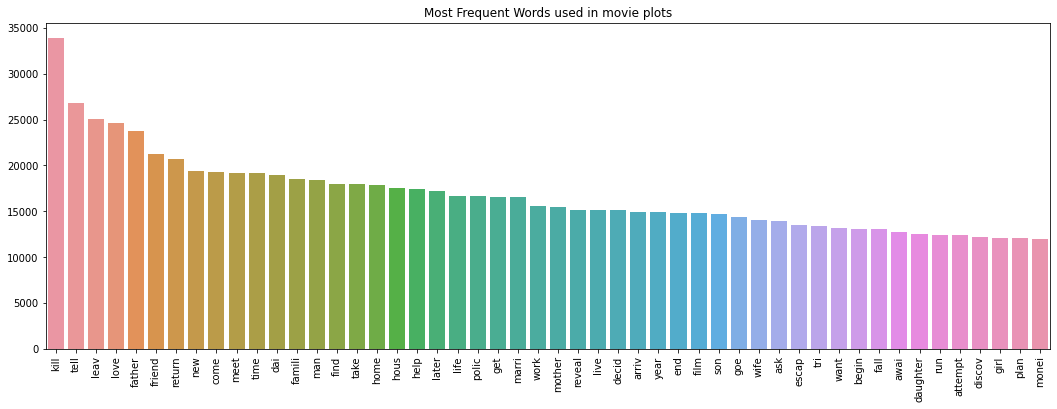

In [19]:
barplot(words=common_words, words_counts=common_words_counts, title='Most Frequent Words used in movie plots')

In [0]:
from itertools import islice

def key_word_counter(tupple):
    return tupple[1]

all_word_counts = sorted(aggregate_counter.items(), key=key_word_counter)
uncommon_words = [word[0] for word in islice(all_word_counts, 50)]
uncommon_word_counts = [word[1] for word in islice(all_word_counts, 50)] 

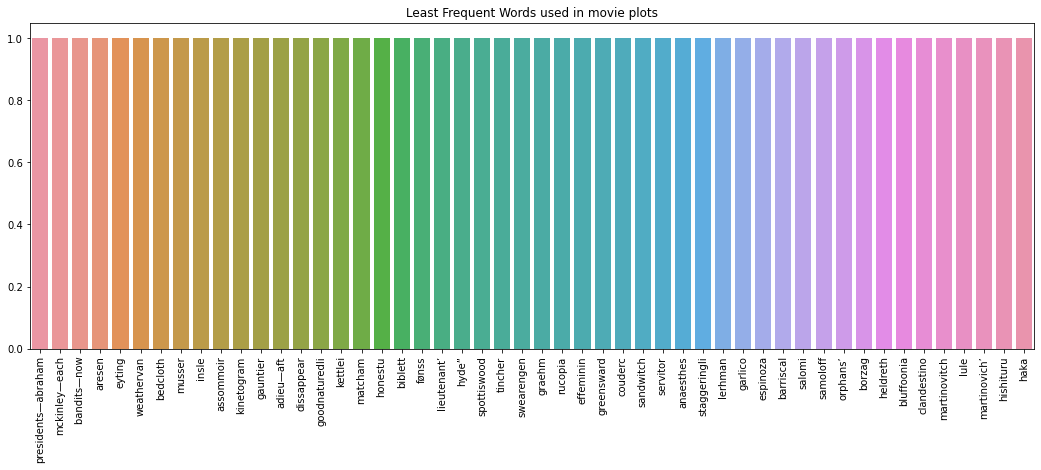

In [21]:
barplot(words=uncommon_words, words_counts=uncommon_word_counts, title='Least Frequent Words used in movie plots')

In [0]:
from gensim.models.doc2vec import TaggedDocument, Doc2Vec
from gensim.parsing.preprocessing import preprocess_string
from sklearn.base import BaseEstimator
from sklearn import utils as skl_utils
from tqdm import tqdm

import multiprocessing
import numpy as np

class Doc2VecTransformer(BaseEstimator):

    def __init__(self, vector_size=100, learning_rate=0.02, epochs=20):
        self.learning_rate = learning_rate
        self.epochs = epochs
        self._model = None
        self.vector_size = vector_size
        self.workers = multiprocessing.cpu_count() - 1

    def fit(self, df_x, df_y=None):
        tagged_x = [TaggedDocument(str(row['Plot']).split(), [index]) for index, row in df_x.iterrows()]
        model = Doc2Vec(documents=tagged_x, vector_size=self.vector_size, workers=self.workers)

        for epoch in range(self.epochs):
            model.train(skl_utils.shuffle([x for x in tqdm(tagged_x)]), total_examples=len(tagged_x), epochs=1)
            model.alpha -= self.learning_rate
            model.min_alpha = model.alpha

        self._model = model
        return self

    def transform(self, df_x):
        return np.asmatrix(np.array([self._model.infer_vector(str(row['Plot']).split())
                                     for index, row in df_x.iterrows()]))
    

In [24]:
doc2vec_tr = Doc2VecTransformer(vector_size=300)
doc2vec_tr.fit(title_plot_df)
doc2vec_vectors = doc2vec_tr.transform(title_plot_df)

100%|██████████| 34886/34886 [00:00<00:00, 3434397.12it/s]


In [25]:
print(doc2vec_vectors)

[[ 1.3108519e-04 -3.3717550e-04  1.6621595e-03 ...  1.0080222e-03
   4.9436640e-04  1.3673940e-04]
 [-9.8810531e-04 -6.2234822e-04  1.2331272e-03 ...  6.7023811e-04
  -1.3804145e-03 -5.7570048e-04]
 [ 1.3526692e-03 -1.0656868e-03  9.9354179e-04 ... -7.4636244e-04
   7.2638504e-04  9.3368307e-04]
 ...
 [-5.9012661e-04 -6.8124398e-05  6.1867503e-04 ... -1.0222257e-03
   9.7435521e-04  1.1021583e-04]
 [-9.1098883e-04  1.3675822e-03  1.2779139e-03 ... -1.2146132e-03
  -1.0625919e-03  1.1058616e-03]
 [-1.5088364e-03  1.0855718e-03  5.7342633e-05 ...  1.1035041e-03
  -5.8355118e-04  1.4090404e-03]]


In [0]:
from sklearn.neural_network import MLPRegressor

auto_encoder = MLPRegressor(hidden_layer_sizes=(
                                                 600,
                                                 150, 
                                                 600,
                                               ))
auto_encoder.fit(doc2vec_vectors, doc2vec_vectors)
predicted_vectors = auto_encoder.predict(doc2vec_vectors)

In [27]:
print(predicted_vectors)

[[-0.00110294 -0.00148531 -0.00110263 ... -0.00049289 -0.0015077
   0.00416529]
 [-0.00104966 -0.00141226 -0.00080577 ... -0.00034377 -0.00158611
   0.00426107]
 [-0.00094334 -0.00138143 -0.00012505 ... -0.00088817 -0.00202245
   0.00437757]
 ...
 [-0.00088322 -0.00137537 -0.00058467 ... -0.00071881 -0.00183279
   0.00428456]
 [-0.00109786 -0.00121452 -0.0008508  ... -0.00037983 -0.00205771
   0.00407038]
 [-0.00105615 -0.00148575 -0.000678   ... -0.00040453 -0.00166076
   0.00448284]]


In [28]:
auto_encoder.score(predicted_vectors, doc2vec_vectors)

/usr/local/lib/python3.6/dist-packages/sklearn/base.py:434: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


0.9561046214986978

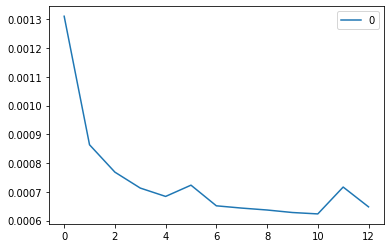

In [29]:
pd.DataFrame(auto_encoder.loss_curve_).plot()

In [0]:
from scipy.spatial.distance import cosine

def key_consine_similarity(tupple):
    return tupple[1]

def get_computed_similarities(vectors, predicted_vectors, reverse=False):
    data_size = len(title_plot_df)
    cosine_similarities = []
    for i in range(data_size):
        cosine_sim_val = (1 - cosine(vectors[i], predicted_vectors[i]))
        cosine_similarities.append((i, cosine_sim_val))

    return sorted(cosine_similarities, key=key_consine_similarity, reverse=reverse)

def display_top_n(sorted_cosine_similarities, n=5):
    for i in range(n):
        index, consine_sim_val = sorted_cosine_similarities[i]
        print('Movie Title: ', title_plot_df.iloc[index, 0])  
        print('Cosine Sim Val :', consine_sim_val)
        print('---------------------------------')

In [31]:
print('Top 5 unique movies')
sorted_cosine_similarities = get_computed_similarities(vectors=doc2vec_vectors, predicted_vectors=predicted_vectors)
display_top_n(sorted_cosine_similarities=sorted_cosine_similarities)

Top 5 unique movies
Movie Title:  Simran
Cosine Sim Val : -0.3549463516247773
---------------------------------
Movie Title:  Pannaiyarum Padminiyum
Cosine Sim Val : -0.3008986371253455
---------------------------------
Movie Title:  Omkara
Cosine Sim Val : -0.28907545611883756
---------------------------------
Movie Title:  Birds Anonymous
Cosine Sim Val : -0.2885572601379729
---------------------------------
Movie Title:  Fierce Creatures
Cosine Sim Val : -0.2866963511216589
---------------------------------


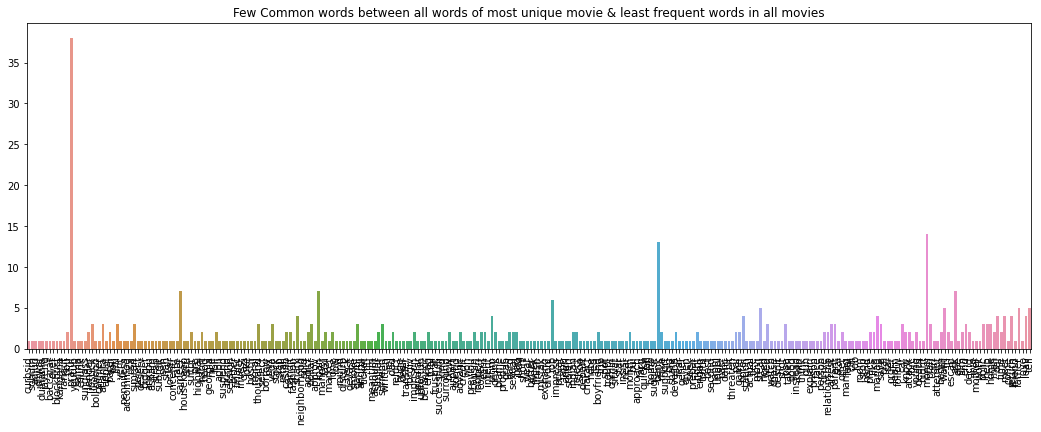

In [33]:
uncommon_word_count_items = [word for word in islice(all_word_counts, 300000)]
all_movies_uncommon_word_counter = Counter(dict(uncommon_word_count_items))
common_word_counter = Counter(aggregate_counter.most_common(1000))
intersected_uncommon_word_counter = all_movies_uncommon_word_counter & most_unique_movie_words_counter
intersected_uncommon_words = [word[0] for word in intersected_uncommon_word_counter.items()]
intersected_uncommon_word_counts = [word[1] for word in intersected_uncommon_word_counter.items()]
barplot(words=intersected_uncommon_words, words_counts=intersected_uncommon_word_counts,
        title='Few Common words between all words of most unique movie & least frequent words in all movies')